# Heat decomposition in ECCO

In [1]:
import numpy as np
import xarray as xr
import xgcm
# Suppress warning messages for a cleaner presentation
# import warnings
# warnings.filterwarnings('ignore')

## Import the ecco_v4_py library into Python
## =========================================

## -- If ecco_v4_py is not installed in your local Python library,
##    tell Python where to find it.

import sys
sys.path.append('/home/jovyan/ECCOv4-py/ECCOv4-py')

import ecco_v4_py as ecco

# Plotting
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
from matplotlib import pyplot as plt
import cartopy as cart
import pyresample

class LLCMapper:

    def __init__(self, ds, dx=0.25, dy=0.25):
        # Extract LLC 2D coordinates
        lons_1d = ds.XC.values.ravel()
        lats_1d = ds.YC.values.ravel()

        # Define original grid
        self.orig_grid = pyresample.geometry.SwathDefinition(lons=lons_1d, lats=lats_1d)

        # Longitudes latitudes to which we will we interpolate
        lon_tmp = np.arange(-180, 180, dx) + dx/2
        lat_tmp = np.arange(-90, 90, dy) + dy/2

        # Define the lat lon points of the two parts.
        self.new_grid_lon, self.new_grid_lat = np.meshgrid(lon_tmp, lat_tmp)
        self.new_grid  = pyresample.geometry.GridDefinition(lons=self.new_grid_lon,
                                                            lats=self.new_grid_lat)

    def __call__(self, da, ax=None, projection=cart.crs.Robinson(), lon_0=-60, **plt_kwargs):

        assert set(da.dims) == set(['face', 'j', 'i']), "da must have dimensions ['face', 'j', 'i']"

        if ax is None:
            fig, ax = plt.subplots(figsize=(12, 6), subplot_kw={'projection': projection})
        else:
            m = plt.axes(projection=projection)

        field = pyresample.kd_tree.resample_nearest(self.orig_grid, da.values,
                                                    self.new_grid,
                                                    radius_of_influence=100000,
                                                    fill_value=None)

        vmax = plt_kwargs.pop('vmax', field.max())
        vmin = plt_kwargs.pop('vmin', field.min())


        x,y = self.new_grid_lon, self.new_grid_lat

        # Find index where data is splitted for mapping
        split_lon_idx = round(x.shape[1]/(360/(lon_0 if lon_0>0 else lon_0+360)))


        p = ax.pcolormesh(x[:,:split_lon_idx], y[:,:split_lon_idx], field[:,:split_lon_idx],
                         vmax=vmax, vmin=vmin, transform=cart.crs.PlateCarree(), zorder=1, **plt_kwargs)
        p = ax.pcolormesh(x[:,split_lon_idx:], y[:,split_lon_idx:], field[:,split_lon_idx:],
                         vmax=vmax, vmin=vmin, transform=cart.crs.PlateCarree(), zorder=2, **plt_kwargs)

        ax.add_feature(cart.feature.LAND, facecolor='0.5', zorder=3)
        label = ''
        if da.name is not None:
            label = da.name
        if 'units' in da.attrs:
            label += ' [%s]' % da.attrs['units']
        cb = plt.colorbar(p, shrink=0.4, label=label)
        return ax

## Connect to Dask Cluster

In [3]:
from dask_gateway import Gateway, GatewayCluster
gateway = Gateway()

In [4]:
gateway.list_clusters()

[]

In [59]:
cluster = gateway.connect(gateway.list_clusters()[0].name)
client = cluster.get_client()

In [117]:
cluster = GatewayCluster()
# cluster.adapt(minimum=2, maximum=10)  # or cluster.scale(n) to a fixed size.
cluster.adapt(minimum=2, maximum=50)  # or cluster.scale(n) to a fixed size.
client = cluster.get_client()

In [118]:
gateway

Gateway<http://10.39.245.173:8000/services/dask-gateway>

In [119]:
cluster

In [120]:
client

Client Scheduler: gateway://traefik-gcp-uscentral1b-prod-dask-gateway.prod:80/prod.842770f3947c4757a6cd42f911614181 Dashboard: /services/dask-gateway/clusters/prod.842770f3947c4757a6cd42f911614181/status,Cluster Workers: 0 Cores: 0 Memory: 0 B


## Add relevant constants

In [9]:
base_dir = '/home/jovyan/'

In [10]:
# Seawater density (kg/m^3)
rhoconst = 1029
## needed to convert surface mass fluxes to volume fluxes

# Heat capacity (J/kg/K)
c_p = 3994

# Constants for surface heat penetration (from Table 2 of Paulson and Simpson, 1977)
R = 0.62
zeta1 = 0.6
zeta2 = 20.0

## Load ECCOv4r3 data from catalog

In [11]:
from intake import open_catalog

cat = open_catalog("https://raw.githubusercontent.com/pangeo-data/pangeo-datastore/master/intake-catalogs/ocean.yaml")
ds0  = cat["ECCOv4r3"].to_dask()

In [12]:
ds0

<xarray.Dataset>
Dimensions:    (face: 13, i: 90, i_g: 90, j: 90, j_g: 90, k: 50, k_l: 50, k_p1: 51, k_u: 50, time: 288, time_snp: 287)
Coordinates:
    Depth      (face, j, i) float32 dask.array<chunksize=(13, 90, 90), meta=np.ndarray>
    PHrefC     (k) float32 dask.array<chunksize=(50,), meta=np.ndarray>
    PHrefF     (k_p1) float32 dask.array<chunksize=(51,), meta=np.ndarray>
    XC         (face, j, i) float32 dask.array<chunksize=(13, 90, 90), meta=np.ndarray>
    XG         (face, j_g, i_g) float32 dask.array<chunksize=(13, 90, 90), meta=np.ndarray>
    YC         (face, j, i) float32 dask.array<chunksize=(13, 90, 90), meta=np.ndarray>
    YG         (face, j_g, i_g) float32 dask.array<chunksize=(13, 90, 90), meta=np.ndarray>
    Z          (k) float32 dask.array<chunksize=(50,), meta=np.ndarray>
    Zl         (k_l) float32 dask.array<chunksize=(50,), meta=np.ndarray>
    Zp1        (k_p1) float32 dask.array<chunksize=(51,), meta=np.ndarray>
    Zu         (k_u) float32 dask.array<chunksize=(50,), meta=np.ndarray>
    drC        (k_p1) float32 dask.array<chunksize=(51,), meta=np.ndarray>
    drF        (k) float32 dask.array<chunksize=(50,), meta=np.ndarray>
    dxC        (face, j, i_g) float32 dask.array<chunksize=(13, 90, 90), meta=np.ndarray>
    dxG        (face, j_g, i) float32 dask.array<chunksize=(13, 90, 90), meta=np.ndarray>
    dyC        (face, j_g, i) float32 dask.array<chunksize=(13, 90, 90), meta=np.ndarray>
    dyG        (face, j, i_g) float32 dask.array<chunksize=(13, 90, 90), meta=np.ndarray>
  * face       (face) int64 0 1 2 3 4 5 6 7 8 9 10 11 12
    hFacC      (k, face, j, i) float32 dask.array<chunksize=(50, 13, 90, 90), meta=np.ndarray>
    hFacS      (k, face, j_g, i) float32 dask.array<chunksize=(50, 13, 90, 90), meta=np.ndarray>
    hFacW      (k, face, j, i_g) float32 dask.array<chunksize=(50, 13, 90, 90), meta=np.ndarray>
  * i          (i) int64 0 1 2 3 4 5 6 7 8 9 ... 80 81 82 83 84 85 86 87 88 89
  * i_g        (i_g) int64 0 1 2 3 4 5 6 7 8 9 ... 80 81 82 83 84 85 86 87 88 89
    iter       (time) int64 dask.array<chunksize=(1,), meta=np.ndarray>
    iter_snp   (time_snp) int64 dask.array<chunksize=(1,), meta=np.ndarray>
  * j          (j) int64 0 1 2 3 4 5 6 7 8 9 ... 80 81 82 83 84 85 86 87 88 89
  * j_g        (j_g) int64 0 1 2 3 4 5 6 7 8 9 ... 80 81 82 83 84 85 86 87 88 89
  * k          (k) int64 0 1 2 3 4 5 6 7 8 9 ... 40 41 42 43 44 45 46 47 48 49
  * k_l        (k_l) int64 0 1 2 3 4 5 6 7 8 9 ... 40 41 42 43 44 45 46 47 48 49
  * k_p1       (k_p1) int64 0 1 2 3 4 5 6 7 8 9 ... 42 43 44 45 46 47 48 49 50
  * k_u        (k_u) int64 0 1 2 3 4 5 6 7 8 9 ... 40 41 42 43 44 45 46 47 48 49
    rA         (face, j, i) float32 dask.array<chunksize=(13, 90, 90), meta=np.ndarray>
    rAs        (face, j_g, i) float32 dask.array<chunksize=(13, 90, 90), meta=np.ndarray>
    rAw        (face, j, i_g) float32 dask.array<chunksize=(13, 90, 90), meta=np.ndarray>
    rAz        (face, j_g, i_g) float32 dask.array<chunksize=(13, 90, 90), meta=np.ndarray>
  * time       (time) datetime64[ns] 1992-01-15 1992-02-13 ... 2015-12-14
  * time_snp   (time_snp) datetime64[ns] 1992-02-01 1992-03-01 ... 2015-12-01
Data variables:
    ADVr_SLT   (time, k_l, face, j, i) float32 dask.array<chunksize=(1, 50, 13, 90, 90), meta=np.ndarray>
    ADVr_TH    (time, k_l, face, j, i) float32 dask.array<chunksize=(1, 50, 13, 90, 90), meta=np.ndarray>
    ADVx_SLT   (time, k, face, j, i_g) float32 dask.array<chunksize=(1, 50, 13, 90, 90), meta=np.ndarray>
    ADVx_TH    (time, k, face, j, i_g) float32 dask.array<chunksize=(1, 50, 13, 90, 90), meta=np.ndarray>
    ADVy_SLT   (time, k, face, j_g, i) float32 dask.array<chunksize=(1, 50, 13, 90, 90), meta=np.ndarray>
    ADVy_TH    (time, k, face, j_g, i) float32 dask.array<chunksize=(1, 50, 13, 90, 90), meta=np.ndarray>
    DFrE_SLT   (time, k_l, face, j, i) float32 dask.array<chunksize=(1, 50, 13, 90, 90), meta=np.ndarray>
    DFrE_TH    (time, k_l, face, j, i) float32 das

In [13]:
#Volume (m^3)
vol = (ds0.rA*ds0.drF*ds0.hFacC).transpose('face','k','j','i')

In [14]:
mapper = LLCMapper(ds0)

# Fast method (since on pangeo all data already like that)

In [15]:
year_start = 1993
year_end = 2015

ds = ds0[['UVELMASS','UVELSTAR','VVELMASS','VVELSTAR','WVELMASS','WVELSTAR','ETAN_snp','THETA_snp',
                        'ETAN','THETA',
                        'TFLUX','oceQsw','ADVx_TH','ADVy_TH','ADVr_TH',
                        'DFxE_TH','DFyE_TH','DFrE_TH','DFrI_TH']].sel(
    time_snp=slice('%i-01-01' % year_start,'%i-01-01' % year_end),time=slice('%i' % year_start,'%i' % (year_end - 1)))

## Create the xgcm 'grid' object

In [16]:
ds['drW'] = ds.hFacW * ds.drF #vertical cell size at u point
ds['drS'] = ds.hFacS * ds.drF #vertical cell size at v point
ds['drC'] = ds.hFacC * ds.drF #vertical cell size at tracer point

In [17]:
# Change time axis of the snapshot variables
ds.time_snp.attrs['c_grid_axis_shift'] = 0.5

In [18]:
# define the connectivity between faces
face_connections = {'face':
                    {0: {'X':  ((12, 'Y', False), (3, 'X', False)),
                         'Y':  (None,             (1, 'Y', False))},
                     1: {'X':  ((11, 'Y', False), (4, 'X', False)),
                         'Y':  ((0, 'Y', False),  (2, 'Y', False))},
                     2: {'X':  ((10, 'Y', False), (5, 'X', False)),
                         'Y':  ((1, 'Y', False),  (6, 'X', False))},
                     3: {'X':  ((0, 'X', False),  (9, 'Y', False)),
                         'Y':  (None,             (4, 'Y', False))},
                     4: {'X':  ((1, 'X', False),  (8, 'Y', False)),
                         'Y':  ((3, 'Y', False),  (5, 'Y', False))},
                     5: {'X':  ((2, 'X', False),  (7, 'Y', False)),
                         'Y':  ((4, 'Y', False),  (6, 'Y', False))},
                     6: {'X':  ((2, 'Y', False),  (7, 'X', False)),
                         'Y':  ((5, 'Y', False),  (10, 'X', False))},
                     7: {'X':  ((6, 'X', False),  (8, 'X', False)),
                         'Y':  ((5, 'X', False),  (10, 'Y', False))},
                     8: {'X':  ((7, 'X', False),  (9, 'X', False)),
                         'Y':  ((4, 'X', False),  (11, 'Y', False))},
                     9: {'X':  ((8, 'X', False),  None),
                         'Y':  ((3, 'X', False),  (12, 'Y', False))},
                     10: {'X': ((6, 'Y', False),  (11, 'X', False)),
                          'Y': ((7, 'Y', False),  (2, 'X', False))},
                     11: {'X': ((10, 'X', False), (12, 'X', False)),
                          'Y': ((8, 'Y', False),  (1, 'X', False))},
                     12: {'X': ((11, 'X', False), None),
                          'Y': ((9, 'Y', False),  (0, 'X', False))}}}

# create the grid object
metrics = {
    ('X',): ['dxC', 'dxG'], # X distances
    ('Y',): ['dyC', 'dyG'], # Y distances
    ('Z',): ['drW', 'drS', 'drC'], # Z distances
    ('X', 'Y'): ['rA', 'rAz', 'rAs', 'rAw'] # Areas
}
grid = xgcm.Grid(ds, periodic=False, face_connections=face_connections,metrics=metrics)

## Number of seconds in each month



In [19]:
delta_t = grid.diff(ds.time_snp, 'T', boundary='fill', fill_value=np.nan)

# Convert to seconds
delta_t = delta_t.astype('f4') / 1e9

# Residual velocities

In [20]:
ds['UVELRES'] = ds['UVELMASS'] + ds['UVELSTAR']
ds['VVELRES'] = ds['VVELMASS'] + ds['VVELSTAR']
ds['WVELRES'] = ds['WVELMASS'] + ds['WVELSTAR']

# Climatological means and anomalies

In [21]:
THETA_c = ds.THETA.groupby('time.month').mean()
UVELRES_c = ds.UVELRES.groupby('time.month').mean()
VVELRES_c = ds.VVELRES.groupby('time.month').mean()
WVELRES_c = ds.WVELRES.groupby('time.month').mean()

THETA_p = ds.THETA.groupby('time.month') - THETA_c
UVELRES_p = ds.UVELRES.groupby('time.month') - UVELRES_c
VVELRES_p = ds.VVELRES.groupby('time.month') - VVELRES_c
WVELRES_p = ds.WVELRES.groupby('time.month') - WVELRES_c

# Compute advection terms

### Tm vm

In [22]:
# horizontal divergences 
circh_Tmvm = \
grid.diff_2d_vector({'X':UVELRES_c * grid.interp(THETA_c,'X',boundary='fill') * ds.dyG * ds.drW,
                     'Y':VVELRES_c * grid.interp(THETA_c,'Y',boundary='fill') * ds.dxG * ds.drS},boundary='fill')

In [23]:
# vertical convergence
circv_Tmvm = grid.diff(WVELRES_c * grid.interp(THETA_c,'Z',boundary='fill') * ds.rA,'Z',boundary='fill')

In [24]:
# total convergence
circ_Tmvm = - circh_Tmvm['X'] - circh_Tmvm['Y'] + circv_Tmvm

In [25]:
# top 300 m integral
circ_Tmvm_50 = circ_Tmvm.isel(k=slice(5)).sum('k')
circ_Tmvm_300 = circ_Tmvm.isel(k=slice(20)).sum('k')

In [28]:
test = circv_Tmvm.sum('k')

In [29]:
test.load()

<xarray.DataArray 'sub-c983c7f31486ccd592b7d527791f1b95' (month: 12, face: 13, j: 90, i: 90)>
array([[[[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
           0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
         [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
           0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
         [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
           0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
         ...,
         [ 3.14194336e+01,  3.01878662e+01,  2.87666016e+01, ...,
           3.11582031e+01,  3.12827759e+01,  3.25786133e+01],
         [ 4.07658691e+01,  3.85917969e+01,  3.60766602e+01, ...,
           4.03779297e+01,  4.05170135e+01,  4.16643066e+01],
         [ 5.11855469e+01,  4.95461426e+01,  4.67036133e+01, ...,
           4.85820312e+01,  4.86845703e+01,  4.97392578e+01]],

        [[ 5.66328125e+01,  5.74824219e+01,  5.47734375e+01, ...,
           5.48281250e+01,  5.50605469e+01,  5.60957031e+01],
         [ 6.97890625e+01,  7.09531250e+01,  6.80615234e+01, ...,
           6.35224609e+01,  6.37050781e+01,  6.50673828e+01],
         [ 8.43046875e+01,  8.43085938e+01,  8.04892578e+01, ...,
           7.28896484e+01,  7.27792969e+01,  7.43251953e+01],
...
           4.32243652e+01,  3.34086914e+01,  3.20703125e+01],
         [-3.98687500e+03, -1.85515625e+03,  9.02718750e+02, ...,
           4.19335938e+01,  3.79775391e+01,  3.40747070e+01],
         [-4.05143750e+03, -1.99467969e+03,  8.59812500e+02, ...,
           3.96406250e+01,  3.61142578e+01,  3.21489258e+01]],

        [[ 8.06093750e+01,  6.90312500e+01,  5.94335938e+01, ...,
           0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
         [ 8.99414062e+01,  7.87539062e+01,  6.71484375e+01, ...,
           0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
         [ 9.77861328e+01,  8.78291016e+01,  7.52822266e+01, ...,
           0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
         ...,
         [ 3.68847656e+01,  3.39012451e+01,  3.15937500e+01, ...,
           0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
         [ 3.79821777e+01,  3.75878906e+01,  3.38149414e+01, ...,
           0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
         [ 3.75429688e+01,  3.37045898e+01,  2.92431641e+01, ...,
           0.00000000e+00,  0.00000000e+00,  0.00000000e+00]]]],
      dtype=float32)
Coordinates:
  * month    (month) int64 1 2 3 4 5 6 7 8 9 10 11 12
  * face     (face) int64 0 1 2 3 4 5 6 7 8 9 10 11 12
  * j        (j) int64 0 1 2 3 4 5 6 7 8 9 10 ... 80 81 82 83 84 85 86 87 88 89
  * i        (i) int64 0 1 2 3 4 5 6 7 8 9 10 ... 80 81 82 83 84 85 86 87 88 89

<GeoAxesSubplot:>

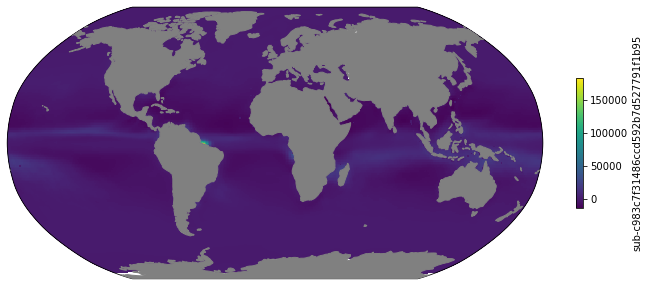

In [31]:
mapper(test.isel(month=0))

In [35]:
test2 = circh_Tmvm['X'].sum('k')

In [36]:
test2.load()

<xarray.DataArray 'sub-1038dd380c138ab08e61128f0d136944' (month: 12, face: 13, j: 90, i: 90)>
array([[[[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
           0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
         [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
           0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
         [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
           0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
         ...,
         [-3.44373094e+05, -1.18860527e+04,  8.32573203e+04, ...,
           1.83926250e+05,  2.13457641e+05,  2.37406312e+05],
         [-1.68802578e+05,  1.73095875e+05,  1.60198766e+05, ...,
           1.50012578e+05,  2.15674547e+05,  2.80165438e+05],
         [ 1.11444508e+05,  2.66852688e+05,  1.09833539e+05, ...,
           7.32317422e+04,  1.69485156e+05,  2.83296312e+05]],

        [[ 2.60249828e+05,  6.62648359e+04, -2.40669781e+05, ...,
          -3.31559453e+04,  6.47949492e+04,  2.22622484e+05],
         [ 1.51307609e+05, -2.90567750e+05, -5.98295000e+05, ...,
          -1.12352727e+05, -8.08992578e+04,  8.69934375e+04],
         [ 4.01846375e+05, -2.49490484e+05, -6.52354625e+05, ...,
          -8.77848438e+04, -2.17086469e+05, -9.31524844e+04],
...
          -1.47305578e+05, -1.49742359e+05,  4.85365344e+05],
         [-1.45336075e+06, -1.54548438e+06, -1.51058212e+06, ...,
          -6.13246312e+05, -7.46357562e+05, -1.12928500e+05],
         [-2.43629344e+05, -6.20846875e+04, -1.53009500e+05, ...,
          -6.31911812e+05, -6.40652500e+05, -3.06697406e+05]],

        [[-1.17959775e+06, -9.74020438e+05, -7.29078375e+05, ...,
           0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
         [-4.21241500e+05, -2.20722844e+05, -6.06293789e+04, ...,
           0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
         [ 8.26163984e+04,  2.13016672e+05,  3.14164062e+05, ...,
           0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
         ...,
         [ 1.07622288e+06,  1.06847812e+06,  5.87456625e+05, ...,
           0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
         [ 7.13907375e+05,  1.13053750e+06,  9.39514938e+05, ...,
           0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
         [ 3.01680094e+05,  7.01208750e+05,  6.90400438e+05, ...,
           0.00000000e+00,  0.00000000e+00,  0.00000000e+00]]]],
      dtype=float32)
Coordinates:
  * month    (month) int64 1 2 3 4 5 6 7 8 9 10 11 12
  * face     (face) int64 0 1 2 3 4 5 6 7 8 9 10 11 12
  * j        (j) int64 0 1 2 3 4 5 6 7 8 9 10 ... 80 81 82 83 84 85 86 87 88 89
  * i        (i) int64 0 1 2 3 4 5 6 7 8 9 10 ... 80 81 82 83 84 85 86 87 88 89

<GeoAxesSubplot:>

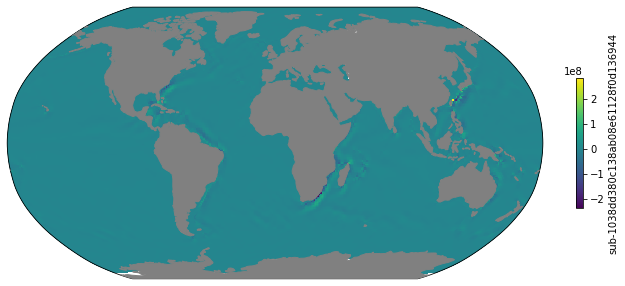

In [37]:
mapper(test2.isel(month=0))

In [38]:
circ_Tmvm_50.load()

<xarray.DataArray (month: 12, face: 13, j: 90, i: 90)>
array([[[[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
           0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
         [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
           0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
         [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
           0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
         ...,
         [-1.00857480e+04, -5.49288623e+03, -9.23802490e+02, ...,
          -5.35268213e+03, -4.97850000e+03, -5.43565820e+03],
         [-1.05238789e+04, -3.07202686e+03,  3.61724414e+03, ...,
          -5.29380566e+03, -4.92690234e+03, -4.87190869e+03],
         [-6.47070898e+03,  1.58778662e+03,  8.40244336e+03, ...,
          -5.49646973e+03, -4.45235059e+03, -3.33368042e+03]],

        [[-4.74991089e+02,  6.08059277e+03,  9.72401953e+03, ...,
          -4.87210156e+03, -4.32322852e+03, -3.42766309e+03],
         [ 1.73797852e+03,  6.46834521e+03,  8.52207129e+03, ...,
          -7.83635742e+03, -7.18929980e+03, -5.40553760e+03],
         [-1.42614258e+02,  4.48368555e+03,  3.81459326e+03, ...,
          -1.08148682e+04, -1.01642578e+04, -8.34751660e+03],
...
          -7.17884961e+03, -1.90764697e+03,  3.29388550e+03],
         [ 7.83877812e+04,  8.49109219e+04,  8.16960312e+04, ...,
          -1.05852148e+04, -6.73518457e+03, -4.95553857e+03],
         [ 8.11443750e+04,  8.64136641e+04,  8.10940781e+04, ...,
          -1.08284043e+04, -1.01193887e+04, -1.09147383e+04]],

        [[-5.36165332e+03, -3.54024707e+03, -6.65451660e+03, ...,
           0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
         [-1.14945332e+04, -1.06538789e+04, -1.20754775e+04, ...,
           0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
         [-1.60148096e+04, -1.58134111e+04, -1.68565723e+04, ...,
           0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
         ...,
         [ 4.70991113e+03,  6.46768848e+03,  6.49054980e+03, ...,
           0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
         [-6.91557324e+03, -6.91902344e+03, -4.46184814e+03, ...,
           0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
         [-1.42456143e+04, -1.41049629e+04, -1.05468564e+04, ...,
           0.00000000e+00,  0.00000000e+00,  0.00000000e+00]]]],
      dtype=float32)
Coordinates:
  * month    (month) int64 1 2 3 4 5 6 7 8 9 10 11 12
  * face     (face) int64 0 1 2 3 4 5 6 7 8 9 10 11 12
  * j        (j) int64 0 1 2 3 4 5 6 7 8 9 10 ... 80 81 82 83 84 85 86 87 88 89
  * i        (i) int64 0 1 2 3 4 5 6 7 8 9 10 ... 80 81 82 83 84 85 86 87 88 89

<GeoAxesSubplot:>

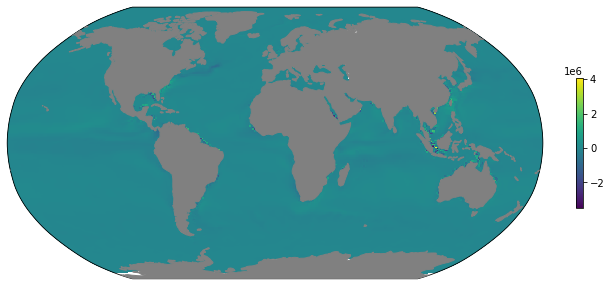

In [40]:
mapper(circ_Tmvm_50.isel(month=0))

In [42]:
circ_Tmvm_50.to_netcdf('circ_Tmvm_50.nc')

In [48]:
circ_Tmvm_300.load()

<xarray.DataArray (month: 12, face: 13, j: 90, i: 90)>
array([[[[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
           0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
         [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
           0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
         [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
           0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
         ...,
         [-1.54328770e+04, -1.75877075e+02,  1.25156387e+04, ...,
           4.29301025e+03,  5.39805762e+03,  5.76613770e+03],
         [-1.76782402e+04,  5.20078271e+03,  2.27473457e+04, ...,
           4.57920850e+03,  7.29787939e+03,  1.02540234e+04],
         [-8.03377979e+03,  1.80316055e+04,  3.79880195e+04, ...,
           3.77889282e+03,  9.11546289e+03,  1.60577197e+04]],

        [[ 1.00125293e+04,  3.27778516e+04,  4.77587344e+04, ...,
           1.73856738e+03,  7.89510059e+03,  1.69311758e+04],
         [ 2.81779492e+04,  3.76982305e+04,  4.71777930e+04, ...,
          -7.08761768e+03, -6.62679688e+02,  1.14634561e+04],
         [ 2.74154414e+04,  2.05649219e+04,  4.70507930e+04, ...,
          -1.72132773e+04, -1.08080186e+04,  4.88073242e+03],
...
           1.45589639e+04,  2.16962207e+04,  3.12901719e+04],
         [ 6.07105500e+05,  6.59469375e+05,  6.37320875e+05, ...,
           1.08236396e+04,  8.83937305e+03,  2.13966992e+03],
         [ 6.34029500e+05,  6.60431688e+05,  6.12244938e+05, ...,
           1.14464180e+04,  5.37798828e+03, -8.93654102e+03]],

        [[ 1.38284023e+04,  2.21694473e+04,  2.71770117e+04, ...,
           0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
         [ 3.83114648e+03,  1.19427383e+04,  1.93069785e+04, ...,
           0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
         [-3.87867188e+02,  7.32535645e+03,  1.43214785e+04, ...,
           0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
         ...,
         [ 4.11250859e+04,  5.53040977e+04,  5.91998672e+04, ...,
           0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
         [-4.43938525e+03, -1.00325928e+02,  8.18362598e+03, ...,
           0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
         [-2.37227070e+04, -2.52085586e+04, -1.53079854e+04, ...,
           0.00000000e+00,  0.00000000e+00,  0.00000000e+00]]]],
      dtype=float32)
Coordinates:
  * month    (month) int64 1 2 3 4 5 6 7 8 9 10 11 12
  * face     (face) int64 0 1 2 3 4 5 6 7 8 9 10 11 12
  * j        (j) int64 0 1 2 3 4 5 6 7 8 9 10 ... 80 81 82 83 84 85 86 87 88 89
  * i        (i) int64 0 1 2 3 4 5 6 7 8 9 10 ... 80 81 82 83 84 85 86 87 88 89

<GeoAxesSubplot:>

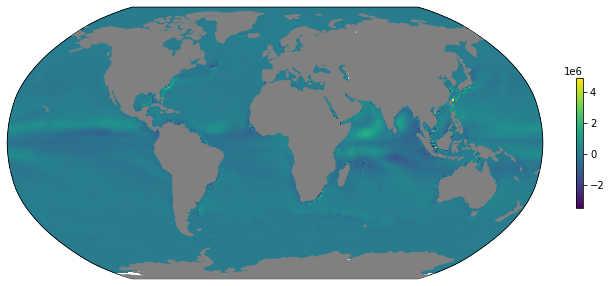

In [50]:
mapper(circ_Tmvm_300.isel(month=0))

In [51]:
circ_Tmvm_300.to_netcdf('circ_Tmvm_300.nc')

### Tm vp

In [52]:
# horizontal divergences 
circh_Tmvp = \
grid.diff_2d_vector({'X':UVELRES_c * grid.interp(THETA_p,'X',boundary='fill').groupby('time.month') * ds.dyG * ds.drW,
                     'Y':VVELRES_c * grid.interp(THETA_p,'Y',boundary='fill').groupby('time.month') * ds.dxG * ds.drS},boundary='fill')

In [53]:
# vertical convergence
circv_Tmvp = grid.diff(WVELRES_c * grid.interp(THETA_p,'Z',boundary='fill').groupby('time.month') * ds.rA,'Z',boundary='fill')

/srv/conda/envs/notebook/lib/python3.8/site-packages/dask/array/core.py:4225: PerformanceWarning: Increasing number of chunks by factor of 13
  result = blockwise(
/srv/conda/envs/notebook/lib/python3.8/site-packages/dask/array/core.py:4225: PerformanceWarning: Increasing number of chunks by factor of 13
  result = blockwise(
/srv/conda/envs/notebook/lib/python3.8/site-packages/dask/array/core.py:4225: PerformanceWarning: Increasing number of chunks by factor of 13
  result = blockwise(
/srv/conda/envs/notebook/lib/python3.8/site-packages/dask/array/core.py:4225: PerformanceWarning: Increasing number of chunks by factor of 13
  result = blockwise(
/srv/conda/envs/notebook/lib/python3.8/site-packages/dask/array/core.py:4225: PerformanceWarning: Increasing number of chunks by factor of 13
  result = blockwise(
/srv/conda/envs/notebook/lib/python3.8/site-packages/dask/array/core.py:4225: PerformanceWarning: Increasing number of chunks by factor of 13
  result = blockwise(
/srv/conda/envs/

In [54]:
# total convergence
circ_Tmvp = - circh_Tmvp['X'] - circh_Tmvp['Y'] + circv_Tmvp

In [55]:
# top 300 m integral
circ_Tmvp_50 = circ_Tmvp.isel(k=slice(5)).sum('k')
circ_Tmvp_300 = circ_Tmvp.isel(k=slice(20)).sum('k')

#### test: one year only

In [77]:
# horizontal divergences 
circh_Tmvp = \
grid.diff_2d_vector({'X':UVELRES_c * grid.interp(THETA_p.sel(time='2014'),'X',boundary='fill').groupby('time.month') * ds.dyG * ds.drW,
                     'Y':VVELRES_c * grid.interp(THETA_p.sel(time='2014'),'Y',boundary='fill').groupby('time.month') * ds.dxG * ds.drS},boundary='fill')

In [78]:
# vertical convergence
circv_Tmvp = grid.diff(WVELRES_c * grid.interp(THETA_p.sel(time='2014'),'Z',boundary='fill').groupby('time.month') * ds.rA,'Z',boundary='fill')

In [79]:
# total convergence
circ_Tmvp = - circh_Tmvp['X'] - circh_Tmvp['Y'] + circv_Tmvp

In [80]:
# top 300 m integral
circ_Tmvp_50 = circ_Tmvp.isel(k=slice(5)).sum('k')
circ_Tmvp_300 = circ_Tmvp.isel(k=slice(20)).sum('k')

In [81]:
circ_Tmvp_50

,Array,Chunk
Bytes,5.05 MB,30.98 kB
Shape,"(12, 13, 90, 90)","(1, 1, 88, 88)"
Count,146590 Tasks,1404 Chunks
Type,float32,numpy.ndarray


In [82]:
circ_Tmvp_50.load()

<xarray.DataArray (time: 12, face: 13, j: 90, i: 90)>
array([[[[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
           0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
         [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
           0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
         [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
           0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
         ...,
         [-2.37483203e+03, -2.14865234e+03, -1.76936865e+03, ...,
          -3.78148975e+03, -2.46142920e+03, -1.19058350e+03],
         [ 8.12707520e+02, -6.10257996e+02, -4.05272766e+02, ...,
          -2.91779858e+03, -1.55929236e+03, -2.10607361e+02],
         [ 8.96150055e+01, -1.72732886e+03, -4.30638489e+02, ...,
          -1.74393188e+03, -5.75219849e+02,  2.51138519e+02]],

        [[-3.34241138e+03, -3.31809619e+03, -9.60964539e+02, ...,
          -2.55340897e+02, -1.61663818e+02, -3.21878876e+02],
         [-4.82610498e+03, -3.57804370e+03, -1.29829565e+03, ...,
          -4.94436646e+00, -4.41731262e+02, -8.53445679e+02],
         [-2.39439355e+03, -1.60397607e+03, -1.83682031e+03, ...,
           5.10560913e+01, -2.91810150e+02, -1.43654370e+03],
...
          -8.24262891e+03, -4.21097900e+03,  4.02326782e+02],
         [ 9.93252930e+03, -4.37534229e+03, -1.62397217e+04, ...,
          -6.98348828e+03, -5.76361279e+03, -3.07276917e+02],
         [ 1.83215645e+04,  3.99068848e+03, -1.04775381e+04, ...,
          -5.15203027e+03, -4.64729980e+03, -8.93585083e+02]],

        [[-2.73250898e+04, -2.79380469e+04, -2.97847109e+04, ...,
           0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
         [-2.03718691e+04, -2.10340605e+04, -2.21128906e+04, ...,
           0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
         [-1.05086387e+04, -1.21717793e+04, -1.22180400e+04, ...,
           0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
         ...,
         [ 2.75694263e+03,  3.26290869e+03,  4.16798730e+03, ...,
           0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
         [ 4.50550879e+03,  6.26008691e+03,  5.71612988e+03, ...,
           0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
         [ 3.66649243e+03,  5.37609277e+03,  2.92041187e+03, ...,
           0.00000000e+00,  0.00000000e+00,  0.00000000e+00]]]],
      dtype=float32)
Coordinates:
  * time     (time) datetime64[ns] 2014-01-15 2014-02-12 ... 2014-12-15
  * face     (face) int64 0 1 2 3 4 5 6 7 8 9 10 11 12
  * j        (j) int64 0 1 2 3 4 5 6 7 8 9 10 ... 80 81 82 83 84 85 86 87 88 89
  * i        (i) int64 0 1 2 3 4 5 6 7 8 9 10 ... 80 81 82 83 84 85 86 87 88 89

In [83]:
circ_Tmvp_50.to_netcdf('circ_Tmvp_50_2014.nc')

### Tp vm

In [121]:
# horizontal divergences 
circh_Tpvm = \
grid.diff_2d_vector({'X':UVELRES_p.sel(time='2014').groupby('time.month') * grid.interp(THETA_c,'X',boundary='fill') * ds.dyG * ds.drW,
                     'Y':VVELRES_p.sel(time='2014').groupby('time.month') * grid.interp(THETA_c,'Y',boundary='fill') * ds.dxG * ds.drS},boundary='fill')

In [122]:
# vertical convergence
circv_Tpvm = grid.diff(WVELRES_p.sel(time='2014').groupby('time.month') * grid.interp(THETA_c,'Z',boundary='fill') * ds.rA,'Z',boundary='fill')

In [123]:
# total convergence
circ_Tpvm = - circh_Tpvm['X'] - circh_Tpvm['Y'] + circv_Tpvm

In [124]:
# top 300 m integral
circ_Tpvm_50 = circ_Tpvm.isel(k=slice(5)).sum('k')
circ_Tpvm_300 = circ_Tpvm.isel(k=slice(20)).sum('k')

In [ ]:
circ_Tpvm_300.load()

In [ ]:
circ_Tpvm_300.to_netcdf('circ_Tpvm_300_2013.nc')

In [125]:
circ_Tpvm_50.load()

<xarray.DataArray (time: 12, face: 13, j: 90, i: 90)>
array([[[[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
           0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
         [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
           0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
         [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
           0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
         ...,
         [ 5.69592188e+03,  1.14369043e+04,  1.41657891e+04, ...,
          -5.48315869e+03, -5.79542432e+03, -5.49879688e+03],
         [ 6.84027344e+03,  1.14782676e+04,  1.14601836e+04, ...,
          -1.22872388e+03,  3.57280273e+01,  5.32671387e+02],
         [ 8.43101367e+03,  1.00597793e+04,  7.42131445e+03, ...,
           1.05705347e+03,  1.03914404e+03,  1.09760791e+03]],

        [[ 7.59215820e+03,  5.71063574e+03,  4.23294824e+03, ...,
          -3.20533691e+02,  4.19230469e+02,  2.67508887e+03],
         [ 4.22576172e+02,  3.87830566e+02, -2.74786865e+03, ...,
           1.37382812e+01,  1.90754883e+03,  7.63811035e+03],
         [-2.08371631e+03, -3.39672852e+03, -5.15318164e+03, ...,
           8.56758301e+02,  5.22122363e+03,  7.50854980e+03],
...
          -2.30819971e+03, -6.95920703e+03, -8.96691992e+03],
         [-3.60887188e+04, -5.01973438e+04, -2.69728125e+04, ...,
          -6.10865283e+03, -1.00131543e+04, -1.10449482e+04],
         [-3.29324062e+04, -5.64641719e+04, -3.32932500e+04, ...,
          -1.15925205e+04, -1.06303057e+04, -1.04508379e+04]],

        [[ 4.06852500e+04,  4.18110234e+04,  4.41154805e+04, ...,
           0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
         [ 3.30181406e+04,  3.63905703e+04,  4.07715547e+04, ...,
           0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
         [ 2.44087148e+04,  2.59510605e+04,  2.87468730e+04, ...,
           0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
         ...,
         [-6.48671582e+03, -3.72533643e+03, -2.12014893e+03, ...,
           0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
         [-7.71338232e+03, -4.61584473e+03, -4.37957520e+03, ...,
           0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
         [-7.59136670e+03, -4.98498145e+03, -4.73686426e+03, ...,
           0.00000000e+00,  0.00000000e+00,  0.00000000e+00]]]],
      dtype=float32)
Coordinates:
  * time     (time) datetime64[ns] 2014-01-15 2014-02-12 ... 2014-12-15
  * face     (face) int64 0 1 2 3 4 5 6 7 8 9 10 11 12
  * j        (j) int64 0 1 2 3 4 5 6 7 8 9 10 ... 80 81 82 83 84 85 86 87 88 89
  * i        (i) int64 0 1 2 3 4 5 6 7 8 9 10 ... 80 81 82 83 84 85 86 87 88 89

In [128]:
cluster.close()

Exception in callback None()
handle: <Handle cancelled>
Traceback (most recent call last):
  File "/srv/conda/envs/notebook/lib/python3.8/site-packages/tornado/iostream.py", line 1391, in _do_ssl_handshake
    self.socket.do_handshake()
  File "/srv/conda/envs/notebook/lib/python3.8/ssl.py", line 1309, in do_handshake
    self._sslobj.do_handshake()
ssl.SSLEOFError: EOF occurred in violation of protocol (_ssl.c:1124)

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/srv/conda/envs/notebook/lib/python3.8/asyncio/events.py", line 81, in _run
    self._context.run(self._callback, *self._args)
  File "/srv/conda/envs/notebook/lib/python3.8/site-packages/tornado/platform/asyncio.py", line 189, in _handle_events
    handler_func(fileobj, events)
  File "/srv/conda/envs/notebook/lib/python3.8/site-packages/tornado/iostream.py", line 696, in _handle_events
    self._handle_read()
  File "/srv/conda/envs/notebook/lib/python3.8/site

In [ ]:
1

In [127]:
circ_Tpvm_50.to_netcdf('circ_Tpvm_50_2014.nc')

# 2 years only

In [87]:
# horizontal divergences 
circh_Tpvm = \
grid.diff_2d_vector({'X':UVELRES_p.groupby('time.month') * grid.interp(THETA_c,'X',boundary='fill') * ds.dyG * ds.drW,
                     'Y':VVELRES_p.groupby('time.month') * grid.interp(THETA_c,'Y',boundary='fill') * ds.dxG * ds.drS},boundary='fill')

In [88]:
# vertical convergence
circv_Tpvm = grid.diff(WVELRES_p.groupby('time.month') * grid.interp(THETA_c,'Z',boundary='fill') * ds.rA,'Z',boundary='fill')

In [89]:
# total convergence
circ_Tpvm = - circh_Tpvm['X'] - circh_Tpvm['Y'] + circv_Tpvm

In [90]:
# top 300 m integral
circ_Tpvm_50 = circ_Tpvm.isel(k=slice(5)).sum('k')
circ_Tpvm_300 = circ_Tpvm.isel(k=slice(20)).sum('k')

### Tp vp

In [91]:
# horizontal divergences 
circh_Tpvp = \
grid.diff_2d_vector({'X':UVELRES_p * grid.interp(THETA_p,'X',boundary='fill') * ds.dyG * ds.drW,
                     'Y':VVELRES_p * grid.interp(THETA_p,'Y',boundary='fill') * ds.dxG * ds.drS},boundary='fill')

In [92]:
# vertical convergence
circv_Tpvp = grid.diff(WVELRES_p * grid.interp(THETA_p,'Z',boundary='fill') * ds.rA,'Z',boundary='fill')

In [93]:
# total convergence
circ_Tpvp = - circh_Tpvp['X'] - circh_Tpvp['Y'] + circv_Tpvp

In [94]:
# top 300 m integral
circ_Tpvp_50  = circ_Tpvp.isel(k=slice(5)).sum('k')
circ_Tpvp_300 = circ_Tpvp.isel(k=slice(20)).sum('k')

## Calculate tendency due to diffusive convergence ($G^{\theta}_\textrm{diffusion}$)

### Horizontal convergence of diffusive heat flux

In [95]:
DFxyE_diff = grid.diff_2d_vector({'X' : ds.DFxE_TH, 'Y' : ds.DFyE_TH}, boundary = 'fill')
# Convergence of horizontal diffusion (degC m^3/s)
dif_hConvH = (-(DFxyE_diff['X'] + DFxyE_diff['Y']))

### Vertical convergence of diffusive heat flux

In [96]:
# Load monthly averages of vertical diffusive fluxes
DFrE_TH = ds.DFrE_TH.transpose('time','face','k_l','j','i')
DFrI_TH = ds.DFrI_TH.transpose('time','face','k_l','j','i')
# Convergence of vertical diffusion (degC m^3/s)
dif_vConvH = grid.diff(DFrE_TH, 'Z', boundary='fill') + grid.diff(DFrI_TH, 'Z', boundary='fill')

### Total convergence of diffusive flux ($G^{\theta}_\textrm{diffusion}$)

In [97]:
# Sum horizontal and vertical convergences and divide by volume (degC.m^3/s)
G_diffusion = dif_hConvH + dif_vConvH

### Mean and anomaly

In [98]:
G_diffusion_c = G_diffusion.groupby('time.month').mean()
G_diffusion_p = G_diffusion.groupby('time.month') - G_diffusion_c

In [99]:
G_diffusion_c_50  = G_diffusion_c.isel(k=slice(5)).sum('k')
G_diffusion_c_300 = G_diffusion_c.isel(k=slice(20)).sum('k')

In [ ]:
G_diffusion_p_50  = G_diffusion_p.isel(k=slice(5)).sum('k')
G_diffusion_p_300 = G_diffusion_p.isel(k=slice(20)).sum('k')

### Mean and anomaly, method 2

In [ ]:
G_diffusion_50  = G_diffusion.isel(k=slice(5)).sum('k')
G_diffusion_300 = G_diffusion.isel(k=slice(20)).sum('k')

In [ ]:
G_diffusion_50_c = G_diffusion_50.groupby('time.month').mean()
G_diffusion_50_p = G_diffusion_50.groupby('time.month') - G_diffusion_50_c
G_diffusion_300_c = G_diffusion_300.groupby('time.month').mean()
G_diffusion_300_p = G_diffusion_300.groupby('time.month') - G_diffusion_300_c

### test dask queue

In [91]:
ds.THETA.isel(face=4,i=20,j=20,k=0,time=slice(10)).sum().load()

KeyboardInterrupt: 

# Loading and saving

In [ ]:
circ_Tmvm_50.load()
circ_Tmvm_300.load()
circ_Tmvm_50.to_netcdf('circ_Tmvm_50.nc')
circ_Tmvm_300.to_netcdf('circ_Tmvm_300.nc')

In [ ]:
circ_Tmvm_50.load()

In [114]:
circ_Tmvp_50.load()

Exception in callback None()
handle: <Handle cancelled>
Traceback (most recent call last):
  File "/srv/conda/envs/notebook/lib/python3.8/site-packages/tornado/iostream.py", line 1391, in _do_ssl_handshake
    self.socket.do_handshake()
  File "/srv/conda/envs/notebook/lib/python3.8/ssl.py", line 1309, in do_handshake
    self._sslobj.do_handshake()
ssl.SSLEOFError: EOF occurred in violation of protocol (_ssl.c:1124)

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/srv/conda/envs/notebook/lib/python3.8/asyncio/events.py", line 81, in _run
    self._context.run(self._callback, *self._args)
  File "/srv/conda/envs/notebook/lib/python3.8/site-packages/tornado/platform/asyncio.py", line 189, in _handle_events
    handler_func(fileobj, events)
  File "/srv/conda/envs/notebook/lib/python3.8/site-packages/tornado/iostream.py", line 696, in _handle_events
    self._handle_read()
  File "/srv/conda/envs/notebook/lib/python3.8/site

CancelledError: ('sum-aggregate-f2997c258dac657f22a7e84c62a73e26', 101, 9, 2, 2)

In [ ]:
1

distributed.client - ERROR - Failed to reconnect to scheduler after 10.00 seconds, closing client
_GatheringFuture exception was never retrieved
future: <_GatheringFuture finished exception=CancelledError()>
asyncio.exceptions.CancelledError
Exception in callback None()
handle: <Handle cancelled>
Traceback (most recent call last):
  File "/srv/conda/envs/notebook/lib/python3.8/site-packages/tornado/iostream.py", line 1391, in _do_ssl_handshake
    self.socket.do_handshake()
  File "/srv/conda/envs/notebook/lib/python3.8/ssl.py", line 1309, in do_handshake
    self._sslobj.do_handshake()
ssl.SSLCertVerificationError: [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: self signed certificate (_ssl.c:1124)

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/srv/conda/envs/notebook/lib/python3.8/asyncio/events.py", line 81, in _run
    self._context.run(self._callback, *self._args)
  File "/srv/conda/envs/notebook/lib/p

In [ ]:
circ_Tmvp_300.load()

In [ ]:
circ_Tmvp_50.to_netcdf('circ_Tmvp_50.nc')
circ_Tmvp_300.to_netcdf('circ_Tmvp_300.nc')

In [ ]:
circ_Tpvp_50.load()
circ_Tpvp_300.load()

circ_Tpvp_50.to_netcdf('circ_Tpvp_50.nc')
circ_Tpvp_300.to_netcdf('circ_Tpvp_300.nc')

In [ ]:
G_diffusion_c_50.load()

In [ ]:
G_diffusion_c_300.load()

In [ ]:
G_diffusion_c_50.to_netcdf('G_diffusion_c_50.nc')
G_diffusion_c_300.to_netcdf('G_diffusion_c_300.nc')

# Testing code

In [98]:
test_u = ds.UVELRES.isel(time=100,k=slice(5)) * grid.interp(ds.THETA.isel(time=100,k=slice(5)),'X',boundary='fill') * ds.dyG * ds.drW.isel(k=slice(5))
test_v = ds.VVELRES.isel(time=100,k=slice(5)) * grid.interp(ds.THETA.isel(time=100,k=slice(5)),'Y',boundary='fill') * ds.dxG * ds.drS.isel(k=slice(5))
test_u.load()
test_v.load()

In [134]:
test_uv = grid.diff_2d_vector({'X':test_u,'Y':test_v},boundary='fill')
test_uv = -test_uv['X'] - test_uv['Y']

(<Figure size 648x568.08 with 17 Axes>,
 array([[-0., -0., -0., ..., -0., -0., -0.],
        [-0., -0., -0., ..., -0., -0., -0.],
        [-0., -0., -0., ..., -0., -0., -0.],
        ...,
        [-0., -0., -0., ...,  0.,  0.,  0.],
        [-0., -0., -0., ...,  0.,  0.,  0.],
        [-0., -0., -0., ...,  0.,  0.,  0.]]))

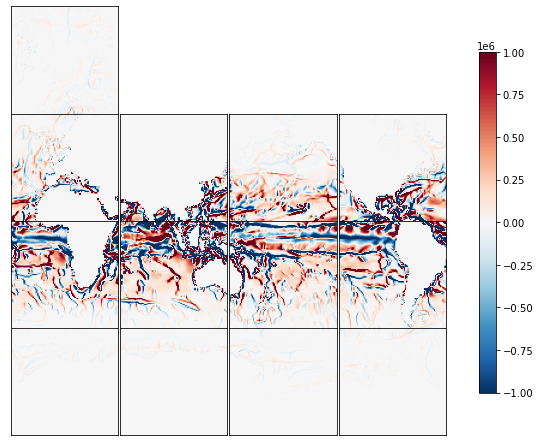

In [139]:
ecco.plot_tiles(test_uv.isel(k=0).rename({'face':'tile'}),
                layout='latlon',rotate_to_latlon=True,show_tile_labels=False,show_colorbar=True,
                cmax=1e6,cmin=-1e6
               )

(<Figure size 648x568.08 with 17 Axes>,
 array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]))

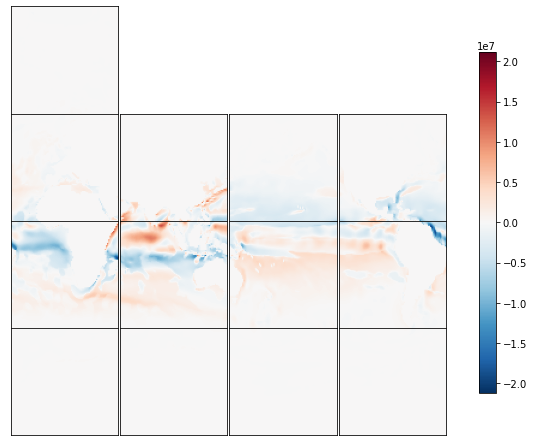

In [101]:
ecco.plot_tiles(test_u.isel(k=0).rename({'face':'tile'}),
                layout='latlon',rotate_to_latlon=True,show_tile_labels=False,show_colorbar=True,
#                 cmax=3e10,cmin=-3e10
               )

(<Figure size 648x568.08 with 17 Axes>,
 array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]))

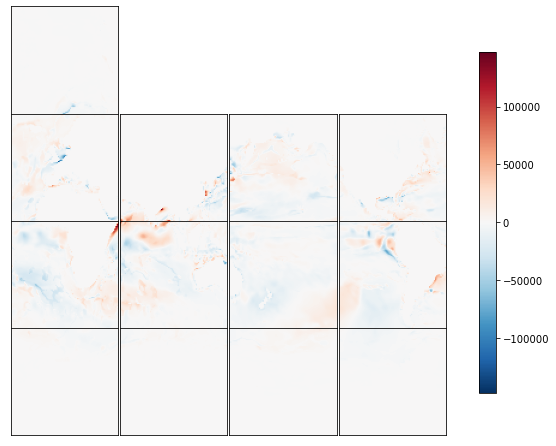

In [108]:
ecco.plot_tiles(test_u.isel(k=0).rename({'face':'tile'}) - ds.ADVx_TH.isel(time=100,k=0).rename({'face':'tile'}),
                layout='latlon',rotate_to_latlon=True,show_tile_labels=False,show_colorbar=True,
#                 cmax=2e5,cmin=-2e5
               )

(<Figure size 648x568.08 with 17 Axes>,
 array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]))

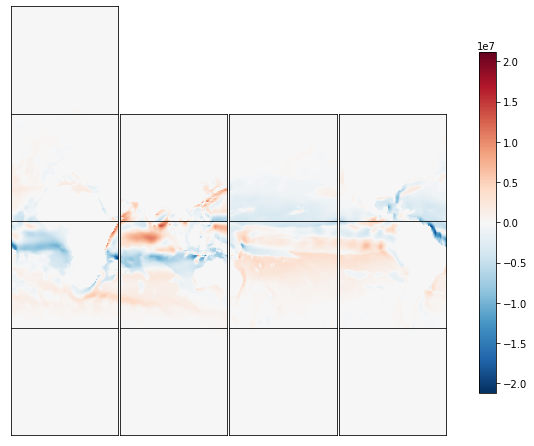

In [104]:
ecco.plot_tiles(ds.ADVx_TH.isel(time=100,k=0).rename({'face':'tile'}),
                layout='latlon',rotate_to_latlon=True,show_tile_labels=False,show_colorbar=True,
#                 cmax=3e10,cmin=-3e10
               )